In [1]:
# =======================================================
# CELL 1: (NO CHANGES NEEDED)
# INSTALL MISSING DEPENDENCIES & ENHANCE FALLBACK
# =======================================================

print("Installing resampy for audio resampling...")
!pip install resampy -q

print("Installation complete.")
!pip install imbalanced-learn -q
print("imbalanced-learn installed successfully.")

# --- Imports and Augmentation Functions ---
import os
import numpy as np
import pandas as pd
import librosa
import resampy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

print("All libraries ready!")

# Enhanced fallback augmentation functions
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
        self.augment = True
        
    def __call__(self, samples, sample_rate):
        try:
            augmented = samples.copy()
            
            # Apply simple augmentations
            if np.random.random() > 0.5:
                # Add Gaussian noise
                noise = np.random.normal(0, 0.005, augmented.shape)
                augmented = augmented + noise
                
            if np.random.random() > 0.5:
                # Time stretching using resampy
                stretch_factor = np.random.uniform(0.8, 1.2)
                if stretch_factor != 1.0:
                    augmented = resampy.resample(augmented, sample_rate, 
                                               int(sample_rate * stretch_factor))
                    # Resample back to original length if needed
                    if len(augmented) != len(samples):
                        augmented = resampy.resample(augmented, 
                                                   int(sample_rate * stretch_factor), 
                                                   sample_rate)
                        # Ensure same length
                        if len(augmented) > len(samples):
                            augmented = augmented[:len(samples)]
                        else:
                            augmented = np.pad(augmented, (0, len(samples) - len(augmented)))
            
            if np.random.random() > 0.5:
                # Volume adjustment
                gain = np.random.uniform(0.7, 1.3)
                augmented = augmented * gain
                
            return augmented
            
        except Exception as e:
            print(f"Augmentation error: {e}")
            return samples  # Return original if augmentation fails

class AddGaussianNoise:
    def __init__(self, min_amplitude=0.001, max_amplitude=0.015, p=0.5):
        self.min_amplitude = min_amplitude
        self.max_amplitude = max_amplitude
        self.p = p
        
class TimeStretch:
    def __init__(self, min_rate=0.8, max_rate=1.2, p=0.5):
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.p = p
        
class PitchShift:
    def __init__(self, min_semitones=-4, max_semitones=4, p=0.5):
        self.min_semitones = min_semitones
        self.max_semitones = max_semitones
        self.p = p

print("Enhanced fallback functions created with proper resampling!")

Installing resampy for audio resampling...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.4 MB/s eta 0:00:00
Installation complete.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 108.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn installed successfully.


2025-10-14 04:01:25.616413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760414485.805339      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760414485.871107      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries ready!
Enhanced fallback functions created with proper resampling!


In [2]:
# =======================================================
# CELL 2: (REPLACE WITH THIS CODE)
# DATA LOADING & BINARY LABELING (COPD vs. Non-COPD)
# =======================================================

# --- Define constants ---
AUDIO_DATA_PATH = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
PATIENT_DATA_PATH = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
SAMPLE_RATE = 22050
DURATION = 3 # seconds to pad/truncate each cycle
N_MFCC = 40 # Number of MFCC features

# --- (Augmenter definition using Compose class from Cell 1) ---
augmenter = Compose([])

# --- Load patient diagnosis data and create a lookup dictionary ---
print("Loading patient diagnosis data...")
diagnosis_df = pd.read_csv(PATIENT_DATA_PATH, names=['patient_id', 'disease'])
diagnosis_df['patient_id'] = diagnosis_df['patient_id'].astype(int)
patient_disease_dict = dict(zip(diagnosis_df.patient_id, diagnosis_df.disease))
print("Diagnosis data loaded.")

# --- Load and process data ---
features = []
labels = []

print("Starting data preparation for binary (COPD/Non-COPD) classification...")
filenames = [f.split('.')[0] for f in os.listdir(AUDIO_DATA_PATH) if f.endswith('.txt')]

for filename in filenames:
    audio_file_path = os.path.join(AUDIO_DATA_PATH, filename + '.wav')
    txt_file_path = os.path.join(AUDIO_DATA_PATH, filename + '.txt')

    try:
        patient_id = int(filename.split('_')[0])
        disease_label = patient_disease_dict.get(patient_id)

        if disease_label:
            # === CHANGE FOR BINARY CLASSIFICATION ===
            # Map the multi-class label to a binary label
            binary_label = 'COPD' if disease_label == 'COPD' else 'Non-COPD'
            # ========================================

            full_audio, _ = librosa.load(audio_file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')
            annotation_data = pd.read_csv(txt_file_path, sep='\t', names=['start', 'end', 'crackles', 'wheezes'])

            for index, row in annotation_data.iterrows():
                start_sample = int(row['start'] * SAMPLE_RATE)
                end_sample = int(row['end'] * SAMPLE_RATE)
                audio_cycle = full_audio[start_sample:end_sample]

                target_length = int(SAMPLE_RATE * DURATION)
                if len(audio_cycle) < target_length:
                    audio_cycle = np.pad(audio_cycle, (0, target_length - len(audio_cycle)), mode='constant')
                else:
                    audio_cycle = audio_cycle[:target_length]
                
                # --- Original Sample with Binary Label ---
                mfcc_original = librosa.feature.mfcc(y=audio_cycle, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
                features.append(mfcc_original)
                labels.append(binary_label) # Append binary label
                
                # --- Augmented Sample with Binary Label ---
                augmented_audio = augmenter(samples=audio_cycle, sample_rate=SAMPLE_RATE)
                mfcc_augmented = librosa.feature.mfcc(y=augmented_audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
                features.append(mfcc_augmented)
                labels.append(binary_label) # Append binary label
        else:
            print(f"Warning: No diagnosis found for patient ID {patient_id}. Skipping file {filename}.")

    except Exception as e:
        print(f"Error processing {audio_file_path}: {e}")

print("Data preparation complete.")

Loading patient diagnosis data...
Diagnosis data loaded.
Starting data preparation for binary (COPD/Non-COPD) classification...
Data preparation complete.


In [3]:
# =======================================================
# CELL 3: (REPLACE WITH THIS CODE)
# PREPROCESSING, SMOTE, AND SPLITTING FOR BINARY DATA
# =======================================================

# --- Convert lists to numpy arrays ---
X = np.array(features)
y = np.array(labels)

# --- Encode text labels ('COPD', 'Non-COPD') to integers (1, 0) ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Store class names for later use
class_names = le.classes_
num_classes = len(class_names)

# --- Split the data into training and testing sets BEFORE resampling ---
# Stratify based on the integer-encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# --- Reshape data for SMOTE (it requires a 2D array) ---
X_train_shape = X_train.shape
X_train_reshaped = X_train.reshape(X_train_shape[0], -1)

# --- Apply SMOTE only to the training data ---
print(f"Shape of X_train before SMOTE: {X_train_reshaped.shape}")
smote = SMOTE(random_state=42)
# Use the integer-encoded y_train for resampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# --- Reshape the training data back to its original 3D format for the CNN/LSTM ---
X_train = X_train_resampled.reshape(-1, X_train_shape[1], X_train_shape[2])
y_train = y_train_resampled

print(f"Shape of X_train after SMOTE: {X_train.shape}")
print("\nTraining data is now balanced.")

# --- Final Data Overview ---
print(f"Final training set shape: {X_train.shape}")
print(f"Final testing set shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names.tolist()}")

Shape of X_train before SMOTE: (11036, 5200)
Shape of X_train after SMOTE: (18386, 130, 40)

Training data is now balanced.
Final training set shape: (18386, 130, 40)
Final testing set shape: (2760, 130, 40)
Number of classes: 2
Class names: ['COPD', 'Non-COPD']


In [4]:
# =======================================================
# CELL 4: (REPLACE WITH THIS CODE)
# BUILD THE BINARY CNN + LSTM MODEL
# =======================================================

input_shape = X_train.shape[1:]

model = Sequential([
    Input(shape=input_shape),
    
    # CNN Block 1
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # CNN Block 2
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # LSTM layer
    LSTM(128, return_sequences=False),
    
    # Classification Head
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # === CHANGE FOR BINARY CLASSIFICATION ===
    # Output layer with 1 neuron and sigmoid activation
    Dense(1, activation='sigmoid')
    # ========================================
])

# --- Compile the model using Binary Crossentropy ---
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    # Use binary_crossentropy for two-class problems
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel compiled for binary classification.")
model.summary()

I0000 00:00:1760415156.970270      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Model compiled for binary classification.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 130, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 65, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,561 (728.75 KB)

 Trainable params: 186,177 (727.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
# =======================================================
# CELL 5: (REPLACE WITH THIS CODE)
# TRAIN AND EVALUATE THE BINARY MODEL
# =======================================================

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# --- EVALUATE THE MODEL ---
print("\n--- Evaluating Model Performance ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n--- Overall Model Performance ---")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print("-" * 35)

# --- Classification Report and Confusion Matrix ---
# Get probabilities for the positive class
predictions_proba = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1) using a 0.5 threshold
predictions = (predictions_proba > 0.5).astype(int)
# y_test is already integer-encoded
y_test_labels = y_test 
class_names = le.classes_

print("\n--- Classification Report ---")
print(classification_report(y_test_labels, predictions, target_names=class_names))
print("-" * 35)

Epoch 1/50


I0000 00:00:1760415163.639951      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


575/575 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8444 - loss: 0.3423 - val_accuracy: 0.9217 - val_loss: 0.1901 - learning_rate: 5.0000e-04
Epoch 2/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9451 - loss: 0.1523 - val_accuracy: 0.8391 - val_loss: 0.4577 - learning_rate: 5.0000e-04
Epoch 3/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9499 - loss: 0.1311 - val_accuracy: 0.9373 - val_loss: 0.2280 - learning_rate: 5.0000e-04
Epoch 4/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9675 - loss: 0.0907 - val_accuracy: 0.9236 - val_loss: 0.1873 - learning_rate: 5.0000e-04
Epoch 5/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9756 - loss: 0.0693 - val_accuracy: 0.9605 - val_loss: 0.0959 - learning_rate: 5.0000e-04
Epoch 6/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9739 - loss: 0.0699 - val_accuracy: 0.9446 - val_loss: 0.1402 - learning_rate: 5.0000e-04
Epoch 7/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9807 - 

Generating model predictions on the test set...
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions generated successfully.
Graphs will be saved in: /kaggle/working/research_graphs_binary


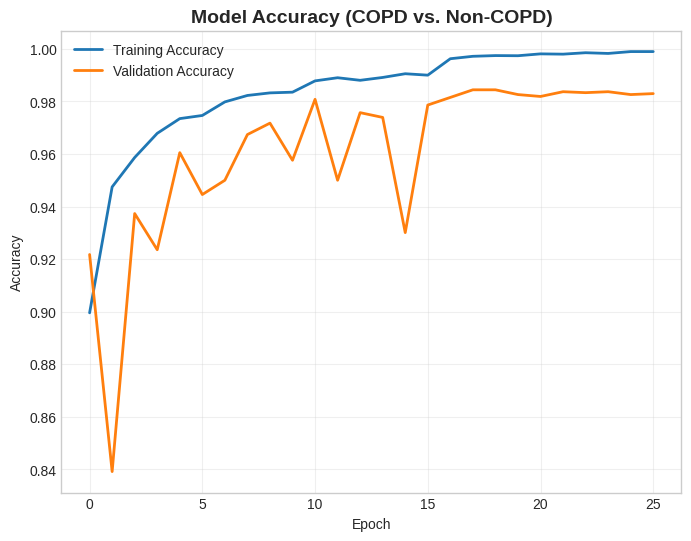

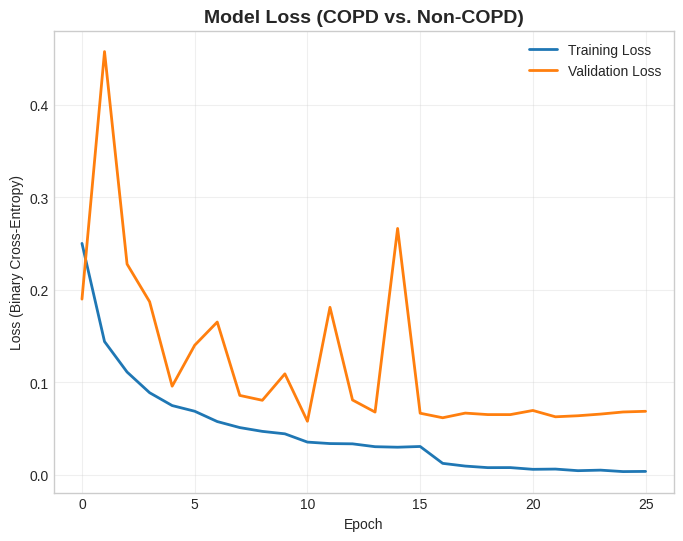

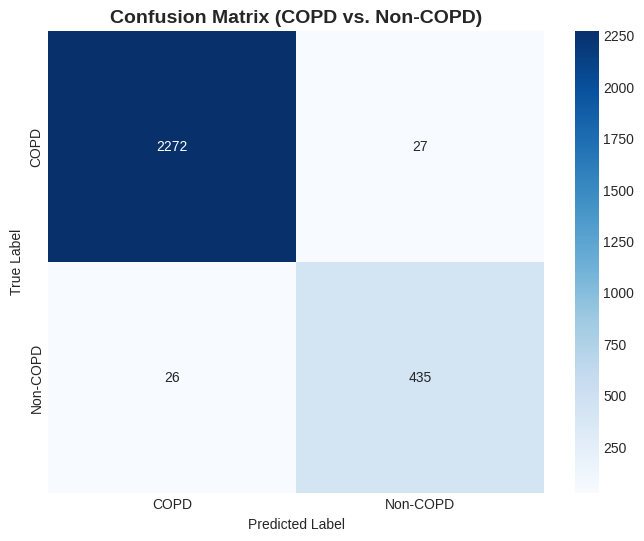


--- AUC Score ---
The Area Under the ROC Curve (AUC) for the model is: 0.9968
-----------------------------------


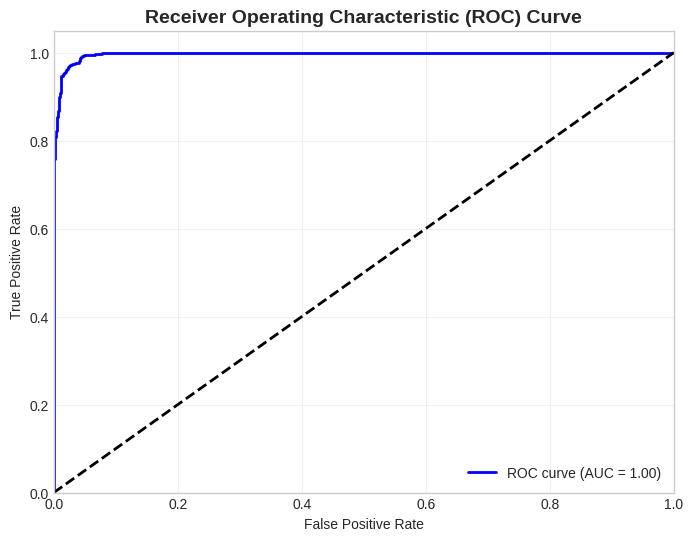

In [6]:
# =================================================================
# CELL 6: VISUALIZATION, AUC SCORE, AND MODEL SAVING (.keras format)
# =================================================================
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import joblib
import json
import tensorflow as tf

# --- 1. PREDICTION AND LABEL PREPARATION ---
print("Generating model predictions on the test set...")
predictions_proba = model.predict(X_test)
predictions = (predictions_proba > 0.5).astype(int)
y_test_labels = y_test
print("Predictions generated successfully.")

# --- 2. SETUP FOR SAVING GRAPHS ---
# This part defines the 'graphs_dir' variable and creates the folder
graphs_dir = "/kaggle/working/research_graphs_binary"
os.makedirs(graphs_dir, exist_ok=True)
print(f"Graphs will be saved in: {graphs_dir}")
plt.style.use('seaborn-v0_8-whitegrid')

# --- 3. GENERATE AND SAVE GRAPHS ---

# --- Graph 1: Training & Validation Accuracy ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy (COPD vs. Non-COPD)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(graphs_dir, '1_binary_model_accuracy.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Graph 2: Training & Validation Loss ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss (COPD vs. Non-COPD)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(graphs_dir, '2_binary_model_loss.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Graph 3: Confusion Matrix ---
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (COPD vs. Non-COPD)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(graphs_dir, '3_binary_confusion_matrix.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Graph 4: ROC Curve & AUC Score ---
fpr, tpr, thresholds = roc_curve(y_test_labels, predictions_proba)
roc_auc = auc(fpr, tpr)

print(f"\n--- AUC Score ---")
print(f"The Area Under the ROC Curve (AUC) for the model is: {roc_auc:.4f}")
print("-" * 35)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2) # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(graphs_dir, '4_binary_roc_curve.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [7]:
# --- 4. SAVE MODEL AND SUPPORTING ASSETS ---
model_dir = "/kaggle/working/saved_model_binary"
os.makedirs(model_dir, exist_ok=True)

# --- 4a. Save the Model in .keras format ---
model.save(os.path.join(model_dir, "copd_binary_model.keras"))
print("Model saved successfully in .keras format.")

# --- 4b. Save the Label Encoder ---
joblib.dump(le, os.path.join(model_dir, "label_encoder_binary.pkl"))
print("Label encoder saved as 'label_encoder_binary.pkl'.")

# --- 4c. Save the Class Names ---
with open(os.path.join(model_dir, "class_names_binary.json"), "w") as f:
    json.dump(class_names.tolist(), f)
print("Class names saved as 'class_names_binary.json'.")

# --- 4d. Save Training History ---
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(model_dir, "training_history_binary.csv"), index=False)
print("Training history saved as 'training_history_binary.csv'.")

# --- List the final saved files ---
print(f"\nAll model assets saved in: {model_dir}")
for file in os.listdir(model_dir):
    print(f"  - {file}")

Model saved successfully in .keras format.
Label encoder saved as 'label_encoder_binary.pkl'.
Class names saved as 'class_names_binary.json'.
Training history saved as 'training_history_binary.csv'.

All model assets saved in: /kaggle/working/saved_model_binary
  - copd_binary_model.keras
  - training_history_binary.csv
  - class_names_binary.json
  - label_encoder_binary.pkl
